In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset
import random
from sklearn.metrics import classification_report
import os # Import os for path joining if needed later

# Cấu hình thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Constants ---
PROJECTION_DIM = 1024 # Define the output dimension for the projection layer
NUM_BASE_CLASSES = 5 # Number of classes the original model was trained on
NUM_RARE_CLASSES = 2 # Number of new rare classes (adjust if different)
TOTAL_CLASSES = NUM_BASE_CLASSES + NUM_RARE_CLASSES 


Using device: cuda


In [2]:
# --- Define Model with Projection Layer ---
class EfficientNetWithProjection(nn.Module):
    def __init__(self, base_model, output_dim=PROJECTION_DIM):
        super(EfficientNetWithProjection, self).__init__()
        self.model = base_model # This holds the EfficientNet base (feature extractor part)
        # EfficientNetB0 outputs 1280 features before the classifier
        in_features = 1280
        self.projection = nn.Linear(in_features, output_dim)

    def forward(self, x):
        # Pass through the base model (feature extractor)
        # No need for torch.no_grad() here if gradients are handled during training setup
        features = self.model(x)
        # Pass features through the projection layer
        return self.projection(features)

# --- Data Loading and Preprocessing ---
# Tiền xử lý dữ liệu hình ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets (Using raw strings for Windows paths is safer)
try:
    full_dataset = datasets.ImageFolder(r"E:\data_optimize\train_fewshot", transform)
    rare_dataset = datasets.ImageFolder(r"E:\Fewshot_rare_data\train", transform)
except FileNotFoundError as e:
    print(f"Error loading datasets: {e}. Please check the paths.")
    exit() # Exit if datasets cannot be loaded

# Offset labels cho rare dataset để tránh trùng lặp
# Ensure the offset makes sense (e.g., if base classes are 0-4, rare start at 5)
rare_dataset.samples = [(path, label + NUM_BASE_CLASSES) for path, label in rare_dataset.samples]

# Kết hợp datasets
combined_dataset = ConcatDataset([full_dataset, rare_dataset])

In [3]:
# Mapping class indices
def get_class_indices(dataset):
    indices = {}
    # Handle ConcatDataset by iterating through its datasets
    if isinstance(dataset, ConcatDataset):
        current_idx = 0
        for ds in dataset.datasets:
            for i in range(len(ds)):
                _, label = ds[i] # Get label directly from sub-dataset item
                # Map the original label (which might have been offset)
                # Need the actual label value stored in ds.samples or similar if accessing directly
                # Let's iterate through samples for robustness
                path, sample_label = ds.samples[i]
                indices.setdefault(sample_label, []).append(current_idx)
                current_idx += 1
    else: # Handle single dataset
        for idx, (_, label) in enumerate(dataset):
             indices.setdefault(label, []).append(idx)
    return indices

class_indices = get_class_indices(combined_dataset)

# Kiểm tra số lượng mẫu mỗi lớp
print("--- Sample counts per class ---")
for cls in sorted(class_indices.keys()):
    print(f"Class {cls}: {len(class_indices[cls])} samples")
print("-------------------------------")

--- Sample counts per class ---
Class 0: 300 samples
Class 1: 300 samples
Class 2: 300 samples
Class 3: 300 samples
Class 4: 300 samples
Class 5: 20 samples
Class 6: 20 samples
-------------------------------


In [4]:
# --- Load Backbone Model ---
# Load the base EfficientNet architecture
model_backbone = models.efficientnet_b0(weights=None) # Load architecture
# Adjust classifier to match the saved state dict (5 classes)
model_backbone.classifier[1] = nn.Linear(model_backbone.classifier[1].in_features, NUM_BASE_CLASSES)

# Load the pre-trained weights for the base classes
try:
    # Use strict=False because we will remove the classifier layer later
    model_backbone.load_state_dict(torch.load(r"E:\Model save\Deep_learning_model\model\efficientnet_coffee (1).pth", map_location=DEVICE), strict=False)
    print("✅ Pre-trained EfficientNet weights loaded.")
except FileNotFoundError:
    print(f"Error: Model weights file not found at E:\\Model save\\Deep_learning_model\\efficientnet_coffee.pth")
    exit()
except Exception as e:
    print(f"Error loading state dict: {e}")
    exit()

# Remove the final classifier layer to use as feature extractor
model_backbone.classifier[1] = nn.Identity()
model_backbone = model_backbone.to(DEVICE) # Move backbone to device
model_backbone.eval() # Set backbone to evaluation mode


C:\Users\hoang\AppData\Local\Temp\ipykernel_14948\1589875809.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_backbone.load_state_dict(torch.load(r"E:\Model save\D

✅ Pre-trained EfficientNet weights loaded.


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
# --- Create Combined Model (Backbone + Projection) ---
model = EfficientNetWithProjection(model_backbone, output_dim=PROJECTION_DIM)
model = model.to(DEVICE)
print(f"Combined model with Projection Layer (output dim: {PROJECTION_DIM}) created.")

# --- Freeze Backbone & Setup Optimizer ---
print("Freezing EfficientNet backbone parameters...")
for param in model.model.parameters(): # Access the backbone via model.model
    param.requires_grad = False

# Ensure projection layer parameters ARE trainable (should be by default)
for param in model.projection.parameters():
     param.requires_grad = True

# Setup optimizer to only train parameters that require gradients (the projection layer)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
print("Optimizer configured to train ONLY the projection layer.")

Combined model with Projection Layer (output dim: 1024) created.
Freezing EfficientNet backbone parameters...
Optimizer configured to train ONLY the projection layer.


In [7]:
# --- Few-Shot Training Setup ---
# (create_episode and proto_loss functions remain the same as in your provided code)
def create_episode(dataset, class_indices, n_way=7, n_shot=5, n_query=5):
    # Check if enough classes are available
    available_classes = list(class_indices.keys())
    if len(available_classes) < n_way:
        print(f"Warning: Not enough classes ({len(available_classes)}) for n_way={n_way}. Using n_way={len(available_classes)}")
        n_way = len(available_classes)
        if n_way < 2: return None # Cannot create episode with < 2 classes

    selected_classes = random.sample(available_classes, n_way)
    support_imgs, query_imgs, support_labels, query_labels = [], [], [], []
    actual_n_way = 0 # Track classes actually added

    # Map selected original class IDs to new episode labels (0 to n_way-1)
    episode_class_map = {class_id: i for i, class_id in enumerate(selected_classes)}

    for original_label in selected_classes:
        indices = class_indices.get(original_label, [])
        if len(indices) < n_shot + n_query:
            # print(f"Skipping class {original_label}: needs {n_shot+n_query}, has {len(indices)}") # Optional warning
            continue  # Bỏ qua lớp không đủ mẫu

        sampled_indices = random.sample(indices, n_shot + n_query)
        try:
            support_imgs += [dataset[i][0] for i in sampled_indices[:n_shot]]
            query_imgs += [dataset[i][0] for i in sampled_indices[n_shot:]]
        except Exception as e:
            print(f"Error accessing dataset index during episode creation: {e}")
            return None # Indicate error

        new_label = episode_class_map[original_label] # Use mapped label
        support_labels += [new_label] * n_shot
        query_labels += [new_label] * n_query
        actual_n_way += 1

    # Check if the episode is valid (at least 2 classes with data)
    if actual_n_way < 2 or not support_imgs:
        # print(f"Episode creation failed or resulted in < 2 classes.")
        return None # Indicate invalid episode

    # Use the actual number of classes successfully added for this episode
    # This requires proto_loss and accuracy calculation to handle variable n_way_actual
    try:
        return (torch.stack(support_imgs).to(DEVICE),
                torch.tensor(support_labels).to(DEVICE), # Labels for this episode
                torch.stack(query_imgs).to(DEVICE),
                torch.tensor(query_labels).to(DEVICE), # Labels for this episode
                actual_n_way) # Return the actual number of ways for this episode
    except Exception as e:
        print(f"Error stacking tensors: {e}")
        return None

In [8]:
# Modify proto_loss to handle variable n_way based on actual labels present
def proto_loss(support_embeddings, support_labels, query_embeddings, query_labels):
    """Calculates the Prototypical Network loss and accuracy for an episode."""
    if support_embeddings is None or support_embeddings.size(0) == 0 or \
       query_embeddings is None or query_embeddings.size(0) == 0:
        return torch.tensor(0.0, requires_grad=True).to(DEVICE), 0.0

    unique_labels = torch.unique(support_labels)
    n_way_actual = len(unique_labels)

    if n_way_actual < 2: return torch.tensor(0.0, requires_grad=True).to(DEVICE), 0.0

    prototypes = []
    label_map = {label.item(): i for i, label in enumerate(unique_labels)} # Map episode label to 0..n_way_actual-1

    for label in unique_labels: # Iterate through the actual labels present
        class_embeddings = support_embeddings[support_labels == label]
        if class_embeddings.size(0) == 0: return torch.tensor(0.0, requires_grad=True).to(DEVICE), 0.0 # Should not happen
        prototypes.append(class_embeddings.mean(dim=0))

    prototypes = torch.stack(prototypes) # Shape [n_way_actual, embedding_dim]

    # Filter query samples to only include labels present in support set
    valid_query_mask = torch.isin(query_labels, unique_labels)
    if not torch.any(valid_query_mask): return torch.tensor(0.0, requires_grad=True).to(DEVICE), 0.0

    filtered_query_embeddings = query_embeddings[valid_query_mask]
    filtered_query_labels = query_labels[valid_query_mask]

    distances = torch.cdist(filtered_query_embeddings, prototypes) # Shape [num_filtered_query, n_way_actual]

    # Map filtered original query labels to the 0..n_way_actual-1 range for loss calculation
    mapped_query_labels = torch.tensor([label_map[lbl.item()] for lbl in filtered_query_labels], dtype=torch.long).to(DEVICE)

    loss = F.cross_entropy(-distances, mapped_query_labels)

    # Accuracy Calculation
    predictions = torch.argmin(distances, dim=1)
    correct_predictions = (predictions == mapped_query_labels).sum().item()
    total_predictions = mapped_query_labels.size(0)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0

    return loss, accuracy


In [9]:

# --- Training Loop ---
n_epochs, episodes_per_epoch, n_way, n_shot, n_query = 10, 20, TOTAL_CLASSES, 5, 5 # Increased episodes, use TOTAL_CLASSES for n_way

print("\n--- Starting Few-Shot Training ---")
# Set the projection layer to train mode, backbone remains in eval mode (due to freezing grads + model_backbone.eval() earlier)
model.projection.train()
# Alternatively, set the whole model to train, the frozen part won't update anyway:
# model.train()

for epoch in range(n_epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    valid_episodes_count = 0

    for i in range(episodes_per_epoch):
        episode_data = create_episode(combined_dataset, class_indices, n_way, n_shot, n_query)
        if episode_data is None:
            # print(f"Skipping episode {i+1} due to insufficient data or classes.")
            continue # Skip if episode creation failed

        s_imgs, s_labels, q_imgs, q_labels, n_way_actual = episode_data
        if n_way_actual < 2: continue # Skip if episode has less than 2 classes

        # Forward pass through the combined model (Frozen Backbone -> Trainable Projection)
        s_emb = model(s_imgs)
        q_emb = model(q_imgs)

        # Calculate loss and accuracy for the episode
        loss, accuracy = proto_loss(s_emb, s_labels, q_emb, q_labels)

        # Backpropagation (only affects projection layer)
        if loss.requires_grad: # Check if loss requires grad before backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_accuracy += accuracy
            valid_episodes_count += 1
        # else: # Optional: print if loss doesn't require grad
        #    print(f"Warning: Loss does not require grad in episode {i+1}")


    if valid_episodes_count > 0:
        avg_loss = epoch_loss / valid_episodes_count
        avg_accuracy = epoch_accuracy / valid_episodes_count
        print(f"Epoch [{epoch+1}/{n_epochs}], Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy*100:.2f}%")
    else:
        print(f"Epoch [{epoch+1}/{n_epochs}], No valid episodes completed.")

print("--- Training Finished ---")


--- Starting Few-Shot Training ---
Epoch [1/10], Avg Loss: 0.1545, Avg Accuracy: 93.86%
Epoch [2/10], Avg Loss: 0.0845, Avg Accuracy: 97.14%
Epoch [3/10], Avg Loss: 0.0478, Avg Accuracy: 98.43%
Epoch [4/10], Avg Loss: 0.0236, Avg Accuracy: 99.86%
Epoch [5/10], Avg Loss: 0.0158, Avg Accuracy: 100.00%
Epoch [6/10], Avg Loss: 0.0206, Avg Accuracy: 99.86%
Epoch [7/10], Avg Loss: 0.0104, Avg Accuracy: 99.86%
Epoch [8/10], Avg Loss: 0.0088, Avg Accuracy: 99.86%
Epoch [9/10], Avg Loss: 0.0109, Avg Accuracy: 99.86%
Epoch [10/10], Avg Loss: 0.0087, Avg Accuracy: 99.86%
--- Training Finished ---


In [10]:
# --- Recalculate Prototypes & Evaluate ---
def calculate_final_prototypes(model, loader): # Renamed from calculate_prototypes to avoid conflict
    model.eval() # Ensure entire model is in eval mode
    embeddings_dict = {}
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(DEVICE)
            emb = model(imgs) # Use the combined model
            for i in range(emb.size(0)):
                label = labs[i].item()
                if label not in embeddings_dict: embeddings_dict[label] = []
                embeddings_dict[label].append(emb[i].cpu())

    prototypes = []
    prototype_labels = []
    # Calculate prototype for each class present in the dictionary keys
    for label in sorted(embeddings_dict.keys()):
        if embeddings_dict[label]: # Check if list is not empty
             class_emb = torch.stack(embeddings_dict[label])
             prototypes.append(class_emb.mean(dim=0))
             prototype_labels.append(label)

    if not prototypes:
        print("Error: Could not calculate any final prototypes.")
        return None, None

    print(f"✅ Final prototypes recalculated for {len(prototype_labels)} classes.")
    return torch.stack(prototypes).to(DEVICE), prototype_labels


train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=False) # Increased batch size
final_prototypes, final_prototype_labels = calculate_final_prototypes(model, train_loader)


✅ Final prototypes recalculated for 7 classes.


In [11]:
# Check if prototypes were calculated successfully
if final_prototypes is None:
    print("Exiting due to prototype calculation failure.")
    exit()

print(f"Shape of final prototypes: {final_prototypes.shape}")
print(f"Labels corresponding to prototypes: {final_prototype_labels}")


# Đánh giá trên tập test
try:
    test_dataset = datasets.ImageFolder(r"E:\CLD_project\test_balanced_fewshot", transform)
    rare_test_dataset = datasets.ImageFolder(r"E:\Fewshot_rare_data\test", transform)
except FileNotFoundError as e:
    print(f"Error loading test datasets: {e}. Please check paths.")
    exit()

rare_test_dataset.samples = [(path, label + NUM_BASE_CLASSES) for path, label in rare_test_dataset.samples]

combined_test_dataset = ConcatDataset([test_dataset, rare_test_dataset])
test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False) # Increased batch size

true_labels, pred_labels = [], []

model.eval() # Ensure model is in eval mode for testing
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        embeddings = model(imgs) # Use combined model to get embeddings

        # Check for dimension mismatch - embeddings vs prototypes
        if embeddings.shape[1] != final_prototypes.shape[1]:
             print(f"ERROR: Dimension mismatch! Embedding dim: {embeddings.shape[1]}, Prototype dim: {final_prototypes.shape[1]}")
             # Handle error appropriately, e.g., skip batch or exit
             continue

        distances = torch.cdist(embeddings, final_prototypes) # Compare to final prototypes

        # Predict based on nearest prototype index, then map back to original label
        pred_prototype_indices = torch.argmin(distances, dim=1).cpu().numpy()
        # Map index back to the actual class label stored in final_prototype_labels
        batch_pred_labels = [final_prototype_labels[idx] for idx in pred_prototype_indices]

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(batch_pred_labels) # Add the mapped labels


# Ensure labels are consistent for classification report
# Get all unique labels present in true_labels and pred_labels
unique_test_labels = sorted(list(set(true_labels) | set(pred_labels)))
# Define target names based on the order of unique labels actually present in the test results
# Assuming your original target_names list corresponds to labels 0 through 6
original_target_names = ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma', 'Nematode', 'Pink disease']
target_names_ordered = []
try:
    target_names_ordered = [original_target_names[i] for i in unique_test_labels if 0 <= i < len(original_target_names)]
    # Handle cases where predicted labels might be outside the range (shouldn't happen if mapping is correct)
    if len(target_names_ordered) != len(unique_test_labels):
         print("Warning: Mismatch between unique test labels and original target names length.")
         # Fallback to just using label numbers if names mismatch
         target_names_ordered = [str(l) for l in unique_test_labels]

except IndexError:
     print("Warning: Label index out of range for original target names. Using numeric labels for report.")
     target_names_ordered = [str(l) for l in unique_test_labels]


print("\n--- Classification Report ---")
# Use the labels parameter to ensure report includes all relevant classes
report = classification_report(true_labels, pred_labels, labels=unique_test_labels, target_names=target_names_ordered, zero_division=0)

print(report)
print("-----------------------------")


Shape of final prototypes: torch.Size([7, 1024])
Labels corresponding to prototypes: [0, 1, 2, 3, 4, 5, 6]

--- Classification Report ---
              precision    recall  f1-score   support

 Cerscospora       1.00      1.00      1.00       300
     Healthy       1.00      1.00      1.00       300
   Leaf rust       1.00      1.00      1.00       300
       Miner       0.99      1.00      1.00       300
       Phoma       1.00      0.99      0.99       300
    Nematode       0.89      0.88      0.89       163
Pink disease       0.93      0.93      0.93       271

    accuracy                           0.98      1934
   macro avg       0.97      0.97      0.97      1934
weighted avg       0.98      0.98      0.98      1934

-----------------------------


              precision    recall  f1-score   support

 Cerscospora       1.00      1.00      1.00       300
     Healthy       1.00      1.00      1.00       300
   Leaf rust       1.00      1.00      1.00       300
       Miner       0.99      1.00      1.00       300
       Phoma       1.00      0.99      0.99       300
    Nematode       0.89      0.88      0.89       163
Pink disease       0.93      0.93      0.93       271

    accuracy                           0.98      1934
   macro avg       0.97      0.97      0.97      1934
weighted avg       0.98      0.98      0.98      1934



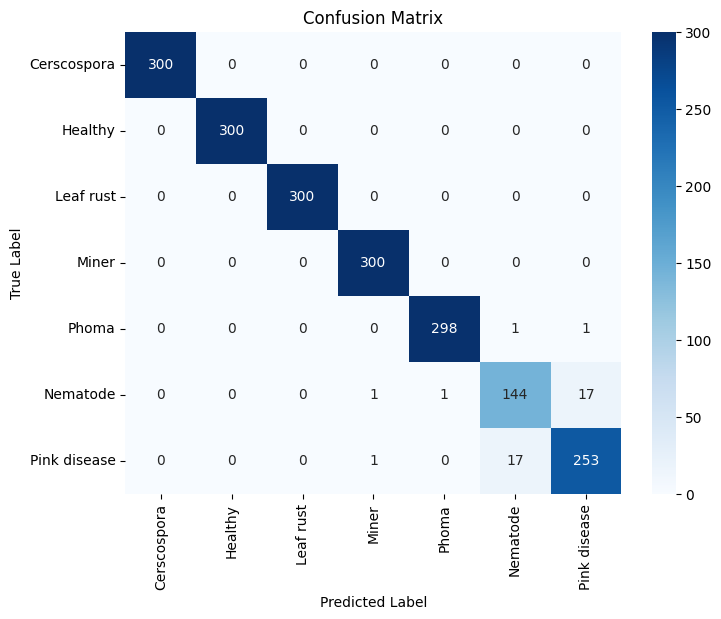

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
class_names = ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma', 'Nematode', 'Pink disease']
report = classification_report(true_labels, pred_labels, target_names=class_names, zero_division=1)
print(report)

# Plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function to plot
plot_confusion_matrix(true_labels, pred_labels, class_names)